<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/NGC_3293/NGC_3293_version_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages and download the csv files

#### Importing packages

In [163]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for downloading file
from google.colab import files

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestClassifier

In [164]:
!pip install astroquery

In [165]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


#### Finding GAIA Data

In [166]:
## making a GAIA cone_search of 30m radius around NGC3293 center

coordinate = coord.SkyCoord.from_name('NGC3293')
print(coordinate)
radius = u.Quantity(0.8, u.deg)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (158.955, -58.23)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [167]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
0,1635721458409799680,Gaia DR2 5351447238429893888,5351447238429893888,128092194,2015.5,158.954102,0.805624,-58.231444,0.904548,1.580851,1.117148,1.415077,-4.596749,2.388422,1.126415,1.994130,-0.155291,-0.269302,-0.217404,0.265403,0.153783,0.319802,-0.401318,-0.286013,0.123788,0.152974,119,0,119,0,3.634906,177.269119,2.194535,2.104447,31,False,0.040210,1.278784,0.193566,-0.159611,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.853035,0.070163,198.531901,-58.785645,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.001517
1,1635721458409799680,Gaia DR2 5351448715898764800,5351448715898764800,528532118,2015.5,158.957741,1.068505,-58.228677,1.123033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88,0,87,1,5.834652,180.582489,3.725129,6.515405,3,False,0.031303,NaN,NaN,-0.116337,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.853325,0.073516,198.530656,-58.782341,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.001956
2,1635721458409799680,Gaia DR2 5351447238429962368,5351447238429962368,1453165503,2015.5,158.954995,1.246294,-58.231988,0.882215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.592404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,0,106,0,3.091953,150.754089,1.830045,1.954333,3,False,0.062480,NaN,NaN,-0.186347,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.853713,0.069924,198.533287,-58.785688,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.001984
3,1635721458409799680,Gaia DR2 5351448715895929728,5351448715895929728,587510854,2015.5,158.955345,0.235379,-58.227730,0.284457,0.506660,0.301901,1.678234,-8.804943,0.570411,8.758619,0.488917,0.243336,-0.097713,0.252344,0.461485,0.391762,0.638010,0.339226,0.157617,0.379714,0.258301,148,0,146,2,6.667548,284.154663,1.082394,6.628915,31,False,0.363259,1.432369,0.048411,-0.043816,...,1515.454641,36.837284,41.139153,16.810562,2.966690,0,0.693451,-0.711847,1.405298,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.851760,0.073712,198.527650,-58.782585,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.002281
4,1635721458409799680,Gaia DR2 5351447238444375936,5351447238444375936,627262602,2015.5,158.952011,0.029027,-58.232539,0.027980,0.343626,0.030318,11.334161,-7.775487,0.058220,3.242510,0.054211,-0.027468,-0.079741,-0.135325,0.513097,0.113623,0.565735,-0.059250,0.134492,0.204688,0.107117,192,0,190,2,-0.442584,175.971069,0.000000,0.000000

##### Applying Filter:

In [168]:
all_stars['pmra_over_error'] = abs(all_stars['pmra']/all_stars['pmra_error'])
all_stars['pmdec_over_error'] = abs(all_stars['pmdec']/all_stars['pmdec_error'])

In [169]:
all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [170]:
all_stars_filtered = all_stars_filtered[(all_stars_filtered['pmdec_over_error'] > 3) & (all_stars_filtered['pmra_over_error'] > 3)]

In [171]:
all_stars_filtered.shape

(57282, 99)

##### Visualizing GAIA data

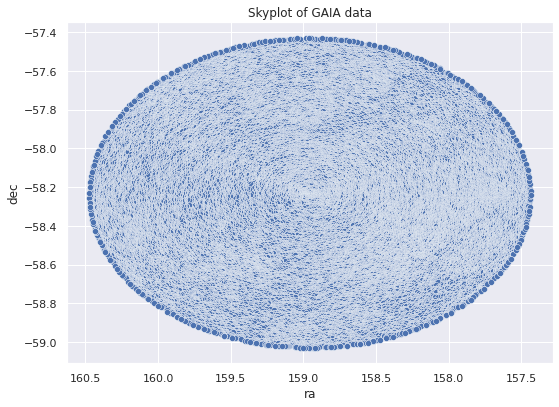

In [172]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', 
                          data = all_stars_filtered)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

#### Finding Cantat Data

In [173]:
#### Finding Cantat catalogue

catalog_list = Vizier.find_catalogs('Cantat')
{k:v.description for k,v in catalog_list.items()}

{'I/349': 'StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)',
 'J/A+A/561/A94': 'Velocities and photometry in Trumpler 20 (Donati+, 2014)',
 'J/A+A/564/A133': 'Gaia FGK benchmark stars: metallicity (Jofre+, 2014)',
 'J/A+A/569/A17': 'Gaia-ESO Survey: NGC6705 (Cantat-Gaudin+, 2014)',
 'J/A+A/582/A81': 'Gaia FGK benchmark stars: abundances (Jofre+, 2015)',
 'J/A+A/588/A120': 'Equivalent widths in 10 open clusters (Cantat-Gaudin+, 2016)',
 'J/A+A/591/A37': 'Gaia-ESO Survey. Parameters for cluster members (Jacobson+, 2016)',
 'J/A+A/597/A10': 'South Ecliptic Pole stars radial velocities (Fremat+, 2017)',
 'J/A+A/598/A68': 'Gaia-ESO Survey. Trumpler 23 (Overbeek+, 2017)',
 'J/A+A/601/A19': 'Gaia DR1 open cluster members (Gaia Collaboration+, 2017)',
 'J/A+A/603/A2': 'Gaia-ESO Survey abundances radial distribution (Magrini+, 2017)',
 'J/A+A/605/A79': 'TGAS Cepheids and RR Lyrae stars (Gaia Collaboration+, 2017)',
 'J/A+A/615/A49': 'TGAS stars membership in 128 open clusters (C

In [174]:
## cheking the tables in the GAIA DR2 paper

Vizier.ROW_LIMIT = -1
#catalogs = Vizier.get_catalogs(catalog_list['J/A+A/633/A99'])
#catalogs

In [175]:
## saving only NGC 3293 data from Cantat GAIA DR2 paper

cantat_3293 = Vizier(catalog = 'J/A+A/633/A99/members', row_limit = -1).query_constraints(Cluster="NGC_3293")
cantat_3293 = cantat_3293[0].to_pandas()
cantat_3293

,RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,RV,Gmag,BP-RP,Proba,Cluster,_RA.icrs,_DE.icrs
0,159.138841,-58.342722,5350695138128318464,0.3842,-7.552,3.372,NaN,14.623600,0.5547,0.9,NGC_3293,159.138903,-58.342736
1,159.028629,-58.310262,5350696134560589440,0.3524,-7.774,3.379,NaN,13.557100,0.5473,1.0,NGC_3293,159.028693,-58.310277
2,158.996248,-58.286858,5350696203280067456,0.3767,-7.613,3.342,NaN,17.210699,1.3604,0.9,NGC_3293,158.996310,-58.286873
3,159.057697,-58.318124,5350695928402160000,0.4028,-7.770,3.212,NaN,13.081900,0.5480,0.9,NGC_3293,159.057761,-58.318138
4,159.064112,-58.309625,5350696031481376384,0.3650,-7.933,2.758,NaN,17.822201,1.4310,0.2,NGC_3293,159.064177,-58.309637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,159.027317,-58.097191,5351543411342576128,0.4411,-8.072,3.098,NaN,17.899300,1.1319,0.1,NGC_3293,159.027382,-58.097205
653,159.091837,-58.115276,5351543170824427520,0.4172,-7.331,2.746,NaN,17.134701,1.2670,0.3,NGC_3293,159.091896,-58.115288
654,159.110404,-58.048860,5351545198049116416,0.4093,-7.743,3.719,NaN,14.627900,0.5725,0.1,NGC_3293,159.110467,-58.048876
655,158.957864,-58.034643,5351544712700452224,0.3125,-7.104,3.262,NaN,15.681900,1.0012,0.1,NGC_3293,158.957922,-58.034657


In [176]:
# renaming the cantat table to match it with gaia_data
cantat_3293 = cantat_3293.rename(columns={'Source':'source_id',
                                          'Proba':'PMemb'})


In [177]:
# taking the subset of only source_id and PMemb
cantat_3293 = cantat_3293.loc[:,['source_id', 'PMemb']]


In [178]:
# join the two table on source_id
cantat_3293 = all_stars_filtered.join(cantat_3293.set_index('source_id'), on='source_id')

In [179]:
# dropping the rows, where we don't have PMemb 
# (i.e. the source id was not in the cantat table)
cantat_3293 = cantat_3293.dropna(subset=['PMemb'])
cantat_3293

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb
4,1635721458409799680,Gaia DR2 5351447238444375936,5351447238444375936,627262602,2015.5,158.952011,0.029027,-58.232539,0.027980,0.343626,0.030318,11.334161,-7.775487,0.058220,3.242510,0.054211,-0.027468,-0.079741,-0.135325,0.513097,0.113623,0.565735,-0.059250,0.134492,0.204688,0.107117,192,0,190,2,-0.442584,175.971069,0.000000,0.000000,31,False,30.069584,1.662618,0.006246,0.016850,...,14.327250,1.236436,0,0.561605,0.171326,0.390280,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.852623,0.068666,198.531933,-58.787197,100001,6851.000000,6484.075195,7365.250000,1.2320,0.9549,1.4393,0.6385,0.4949,0.7351,200111,2.010348,1.739419,2.244311,8.021451,6.308611,9.734291,https://gea.esac.esa.int/data-server/datalink/...,,0.002987,133.553630,59.813159,1.0
10,1635721458409799680,Gaia DR2 5351447238444383744,5351447238444383744,230283850,2015.5,158.946719,0.036591,-58.227077,0.036062,0.278193,0.042357,6.567760,-7.834517,0.067352,3.125448,0.069531,0.010594,-0.214257,-0.261037,0.276264,0.220526,0.323439,-0.008844,0.276007,0.133519,0.007996,170,170,165,5,11.251204,456.114624,0.048191,0.697239,31,False,180.741867,1.770945,0.010376,-0.101524,...,11.515003,1.187820,1,0.037317,-0.012627,0.049944,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.847493,0.072023,198.520631,-58.785382,102002,9480.333008,6217.333496,9613.000000,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.005258,116.321703,44.950617,0.8
14,1635721458409799680,Gaia DR2 5351448715913147904,5351448715913147904,1172023644,2015.5,158.955427,0.037934,-58.224267,0.041066,0.361111,0.047680,7.573609,-7.745214,0.070516,3.234497,0.078859,0.097815,-0.356171,-0.212339,0.097971,0.004786,0.248625,-0.321791,0.067943,0.273823,0.039968,213,213,205,8,14.106810,634.158997,0.113007,4.174742,31,False,54.696457,1.774363,0.009639,-0.058666,...,6.434452,1.155608,0,0.038411,0.017635,0.020776,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.850078,0.076739,198.522922,-58.780137,100001,9002.000000,7904.500000,9478.000000,0.0763,0.0189,0.3038,0.0480,0.0113,0.1380,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.005742,109.836772,41.016178,1.0
18,1635721458409799680,Gaia DR2 5351448505437777280,5351448505437777280,3140375,2015.5,158.965521,0.034032,-58.227546,0.035259,0.340286,0.043593,7.806006,-7.750376,0.070863,3.108346,0.073514,0.222115,-0.387199,0.062676,0.209676,0.051695,0.373335,0.037221,-0.113833,0.263384,0.135983,186,151,184,2,10.521373,459.741333,0.000000,0.000000,31,False,202.741119,1.751290,0.007475,-0.151637,...,12.557397,1.192920,1,0.173354,0.035826,0.137528,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.856319,0.076531,198.534608,-58.778618,100002,9283.500000,8456.250000,9696.000000,0.7537,0.6924,0.87

In [180]:
# saving both cantat and Gaia files as csv
# if you want to save, comment out the next two lines

cantat_3293.to_csv('NGC_3293_cantat.csv')
# all_stars.to_csv('NGC_3293_Gaia_30m.csv')

In [181]:
cantat_3293.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb
count,6.170000e+02,6.170000e+02,6.170000e+02,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,6.060000e+02,606.000000,606.000000,606.000000,606.000000,617.000000,606.000000,606.000000,606.000000,4.000000,4.000000,617.000000,4.000000,4.000000,4.0,617.000000,617.000000,617.000000,617.000000,542.000000,542.000000,542.000000,542.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,289.0,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,617.000000,617.000000,617.000000,617.000000
mean,1.635721e+18,5.351256e+18,8.363382e+08,2015.5,158.941904,0.041943,-58.223179,0.040669,0.377758,0.048224,9.646549,-7.585979,0.081004,3.312147,0.078552,-0.034065,-0.277253,-0.289735,0.269403,0.176014,0.343567,-0.078138,0.187742,0.107994,0.056990,202.012966,30.241491,200.594814,1.418152,1.933214,253.842484,0.045447,0.890093,31.0,57.463230,1.612082,0.009867,-0.019965,23.179903,14.363047,...,3.179429e+05,1402.647664,415.899536,14.194469,1.287667,0.126418,0.800674,0.281763,0.518911,-4.272901,1.939050,0.047002,5125.000000,3.750000,0.0,285.843385,0.074071,198.511906,-58.784460,100244.710332,6671.687500,6329.378418,7030.716309,0.887406,0.594932,1.159183,0.445821,0.296745,0.580796,200111.0,4.597406,4.195796,5.021256,204.749573,168.066162,241.432739,0.088519,116.088744,52.011062,0.623826
std,0.000000e+00,3.282539e+14,4.900179e+08,0.0,0.143802,0.022872,0.071464,0.021987,0.055162,0.025881,4.179525,0.297270,0.043753,0.258574,0.041686,0.130535,0.128759,0.134003,0.110426,0.135790,0.107464,0.168650,0.121315,0.124428,0.137145,29.852339,69.235916,29.937237,2.198035,4.982976,161.599686,0.100777,3.780193,0.0,91.347198,0.104319,0.005260,0.067146,3.384224,1.805780,...,3.238660e+06,18635.188164,295.304871,1.807223,0.122409,0.369581,0.480531,0.217601,0.284884,16.832975,2.896037,0.634041,478.713562,0.866025,0.0,0.077342,0.069729,0.147941,0.070473,654.799456,1716.841797,1620.376953,1746.008789,0.403292,0.382866,0.449504,0.203589,0.190589,0.229465,0.0,32.267616,30.286135,35.228199,3162.824707,2605.815430,3719.859619,0.055579,47.873137,21.882236,0.332883
min,1.635721e+18,5.350689e+18,4.845840e+05,2015.5,158.586102,0.016119,-58.422563,0.014866,0.249344,0.017534,3.011133,-8.527944,0.030638,2.396999,0.029315,-0.656215,-0.756654,-0.869462,-0.153854,-0.480639,-0.222594,-0.718883,-0.488736,-0.576839,-0.569122,61.000000,0.00000

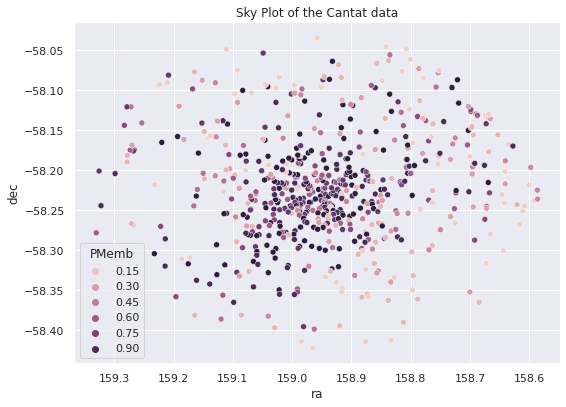

In [182]:
## plotting the skyplot 

skyplot = sns.scatterplot(x = cantat_3293['ra'], y = cantat_3293['dec'], 
                          hue = cantat_3293['PMemb'])
skyplot.invert_xaxis()
plt.title('Sky Plot of the Cantat data')
plt.show()

### Creating, Examining and Processing the Training Data


#### Training Data

In [183]:
# import member dataset
member = cantat_3293.copy()

In [184]:
### adding their distance from the center of the clusters

## NGC 3293
center = coord.SkyCoord.from_name('NGC3293')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((member['ra'] - center_ra)*np.cos(np.radians(member['dec'])))**2 + (member['dec'] - center_dec)**2 )
member['dist_3293_center'] = distance

In [185]:
# maximum distance of stars in Cantat Data
cantat_radius = max(member.dist_3293_center)
cantat_radius

0.2031873079382218

In [186]:
member['member'] = np.full(len(member), 1)
member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3293_center,member
4,1635721458409799680,Gaia DR2 5351447238444375936,5351447238444375936,627262602,2015.5,158.952011,0.029027,-58.232539,0.027980,0.343626,0.030318,11.334161,-7.775487,0.058220,3.242510,0.054211,-0.027468,-0.079741,-0.135325,0.513097,0.113623,0.565735,-0.059250,0.134492,0.204688,0.107117,192,0,190,2,-0.442584,175.971069,0.000000,0.000000,31,False,30.069584,1.662618,0.006246,0.016850,...,0,0.561605,0.171326,0.390280,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.852623,0.068666,198.531933,-58.787197,100001,6851.000000,6484.075195,7365.25,1.2320,0.9549,1.4393,0.6385,0.4949,0.7351,200111,2.010348,1.739419,2.244311,8.021451,6.308611,9.734291,https://gea.esac.esa.int/data-server/datalink/...,,0.002987,133.553630,59.813159,1.0,0.002987,1
10,1635721458409799680,Gaia DR2 5351447238444383744,5351447238444383744,230283850,2015.5,158.946719,0.036591,-58.227077,0.036062,0.278193,0.042357,6.567760,-7.834517,0.067352,3.125448,0.069531,0.010594,-0.214257,-0.261037,0.276264,0.220526,0.323439,-0.008844,0.276007,0.133519,0.007996,170,170,165,5,11.251204,456.114624,0.048191,0.697239,31,False,180.741867,1.770945,0.010376,-0.101524,...,1,0.037317,-0.012627,0.049944,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.847493,0.072023,198.520631,-58.785382,102002,9480.333008,6217.333496,9613.00,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.005258,116.321703,44.950617,0.8,0.005250,1
14,1635721458409799680,Gaia DR2 5351448715913147904,5351448715913147904,1172023644,2015.5,158.955427,0.037934,-58.224267,0.041066,0.361111,0.047680,7.573609,-7.745214,0.070516,3.234497,0.078859,0.097815,-0.356171,-0.212339,0.097971,0.004786,0.248625,-0.321791,0.067943,0.273823,0.039968,213,213,205,8,14.106810,634.158997,0.113007,4.174742,31,False,54.696457,1.774363,0.009639,-0.058666,...,0,0.038411,0.017635,0.020776,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.850078,0.076739,198.522922,-58.780137,100001,9002.000000,7904.500000,9478.00,0.0763,0.0189,0.3038,0.0480,0.0113,0.1380,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.005742,109.836772,41.016178,1.0,0.005737,1
18,1635721458409799680,Gaia DR2 5351448505437777280,5351448505437777280,3140375,2015.5,158.965521,0.034032,-58.227546,0.035259,0.340286,0.043593,7.806006,-7.750376,0.070863,3.108346,0.073514,0.222115,-0.387199,0.062676,0.209676,0.051695,0.373335,0.037221,-0.113833,0.263384,0.135983,186,151,184,2,10.521373,459.741333,0.000000,0.000000,31,False,202.741119,1.751290,0.007475,-0.151637,...,1,0.173354,0.035826,0.137528,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.856319,0.076531,198.534608,-58.778618,100002,9283.500000,8456.250000,9696.00,0.7537,0.6924,0.8717,0.3790,0.3416,0.4556,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.in

In [187]:
### adding their distance from the center of the clusters

## NGC 3293
center = coord.SkyCoord.from_name('NGC3293')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((all_stars_filtered['ra'] - center_ra)*np.cos(np.radians(all_stars_filtered['dec'])))**2 + (all_stars_filtered['dec'] - center_dec)**2 )
all_stars_filtered['dist_3293_center'] = distance

In [188]:
non_member = all_stars_filtered[all_stars_filtered['dist_3293_center'] >= 0.7].sample(len(member), random_state = 42)

In [189]:
non_member['member'] = np.full(len(non_member), 0)
non_member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,dist_3293_center,member
249807,1635721458409799680,Gaia DR2 5351474039041813888,5351474039041813888,652824277,2015.5,157.610972,0.056926,-58.444827,0.055909,0.830593,0.068072,12.201602,-8.787395,0.113805,1.757457,0.103539,-0.123660,-0.193962,-0.162882,0.175939,0.236225,0.252229,0.010682,0.183835,0.135297,-0.058210,222,0,222,0,-0.654589,203.008453,0.0,0.0,31,False,3.195063,1.483368,0.015784,0.176686,...,1.284740,0,1.317078,0.567207,0.749870,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.352332,-0.470077,197.877876,-59.441275,100001,4911.602539,4610.000000,5130.333496,0.3060,0.1659,0.3807,0.1445,0.0730,0.1806,200111,0.628804,0.576329,0.713772,0.207309,0.171341,0.243277,https://gea.esac.esa.int/data-server/datalink/...,,0.737475,77.214781,16.973881,0.735432,0
258237,1635721458409799680,Gaia DR2 5351501904790344064,5351501904790344064,1087828381,2015.5,157.611962,0.055883,-57.984930,0.052178,0.677647,0.070507,9.611109,-7.918658,0.121907,3.440020,0.137540,0.083874,-0.390175,-0.204852,0.174207,-0.023709,0.142601,0.041249,-0.004991,-0.359037,0.457479,223,0,222,1,1.586331,251.018173,0.0,0.0,31,False,3.709239,1.569201,0.013556,-0.029049,...,1.250429,0,1.113459,0.466253,0.647205,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.116557,-0.075213,197.230330,-59.121754,100001,5064.140137,4880.000000,5523.109863,0.1605,0.0659,0.3741,0.0720,0.0320,0.1861,200111,0.754330,0.634169,0.812331,0.337163,0.263145,0.411181,https://gea.esac.esa.int/data-server/datalink/...,,0.750686,64.956764,25.011088,0.752998,0
249453,1635721458409799680,Gaia DR2 5351513793261307392,5351513793261307392,769572060,2015.5,157.667537,0.081291,-57.947290,0.072865,0.354496,0.100557,3.525324,-13.378918,0.174419,3.846887,0.187769,0.067851,-0.317128,-0.261349,0.046884,-0.005465,-0.002425,-0.058829,0.191825,-0.281587,0.304662,217,0,216,1,0.205448,214.573761,0.0,0.0,31,False,1.724434,1.502496,0.020543,-0.025437,...,1.259980,0,1.156656,0.484905,0.671751,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.122537,-0.027779,197.217885,-59.074374,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.736938,76.705673,20.487377,0.739434,0
248284,1635721458409799680,Gaia DR2 5255396926309395968,5255396926309395968,1517295606,2015.5,157.650828,0.036410,-58.499068,0.035307,0.340727,0.044560,7.646499,-4.878301,0.072348,2.715200,0.067475,-0.085293,-0.315942,-0.219038,0.137284,0.291851,0.238594,-0.010965,0.319298,0.004736,0.132835,248,0,248,0,-0.765997,225.865891,0.0,0.0,31,False,7.466182,1.524026,0.009994,0.080486,...,1.276188,0,1.208879,0.504101,0.704778,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,285.398065,-0.505924,197.983411,-59.463622,100001,4874.283203,4824.850098,5007.479980,NaN,NaN,NaN,NaN,NaN,NaN,200111,2.286123,2.166121,2.33320

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


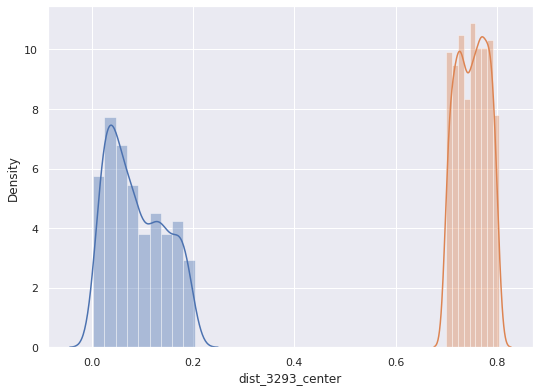

In [190]:
sns.distplot(member['dist_3293_center'])
sns.distplot(non_member['dist_3293_center'])
plt.show()

In [191]:
training_data = pd.concat([member, non_member])

In [192]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3293_center,member
count,1.234000e+03,1.234000e+03,1.234000e+03,1234.0,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.00000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.0,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,...,1208.000000,1208.000000,1208.000000,1234.000000,1208.000000,1208.000000,1208.000000,12.000000,12.000000,1234.000000,12.000000,12.000000,12.000000,1234.000000,1234.000000,1234.000000,1234.000000,875.000000,875.000000,875.000000,875.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,530.0,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,1234.000000,1234.000000,1234.000000,617.000000,1234.000000,1234.000000
mean,1.635721e+18,5.342715e+18,8.413379e+08,2015.5,158.920634,0.064688,-58.205356,0.062447,0.524919,0.076300,9.872985,-7.553600,0.129716,3.419665,0.123996,-0.032563,-0.269797,-0.251242,0.198596,0.180080,0.261009,-0.057208,0.194216,0.056866,0.087479,217.36953,17.275527,216.064019,1.305511,1.572445,267.426697,0.123069,1.568754,31.0,36.379402,1.551750,0.016294,0.007857,24.895462,15.205024,...,351.693268,15.018073,1.338026,0.106969,1.096031,0.425283,0.670748,2.278200,2.070299,0.057536,5083.333496,3.583333,-0.125000,285.826128,0.082381,198.475126,-58.779410,100174.848000,6071.597656,5784.722168,6400.096191,0.890406,0.632790,1.162851,0.445671,0.315371,0.581191,200111.0,3.694886,3.346685,4.032586,114.695412,94.132210,135.258392,0.419589,98.362103,46.473851,0.623826,0.419648,0.500000
std,0.000000e+00,2.723653e+16,4.930574e+08,0.0,0.736513,0.083950,0.369462,0.084751,0.481922,0.101164,8.135184,3.566522,0.178472,2.608535,0.173990,0.125998,0.118028,0.132648,0.126468,0.125315,0.136619,0.160999,0.115917,0.127341,0.142561,30.66137,54.991486,30.764521,1.839422,5.287543,305.689453,0.420135,11.731051,0.0,75.394394,0.120890,0.021821,0.070839,3.458421,1.746072,...,302.318909,1.826104,0.210644,0.360094,0.566496,0.296230,0.315749,15.212722,2.199546,0.621926,596.708130,0.701729,0.433013,0.369525,0.387946,0.698976,0.394780,563.690795,1642.073853,1543.999023,1682.897095,0.568576,0.549412,0.625944,0.285473,0.273151,0.315915,0.0,23.944218,22.461908,26.144596,2335.814209,1924.435913,2747.208984,0.334177,71.679856,41.973025,0.332883,0.334223,0.500203
min,1.635721e+18,5.254573e+18,4.845840e+05,2015.5,157.437030,0.013602,-59.027482,0.013475,0.139367,0.016050,3.000666,-41.424782,0.027258,-30.306074,0.025882,-0.656215,-0.756654,-0.869462,-0.215067,-0.480639,-0.222594,-0.718883,-0.488736,

In [193]:
# Choosing the features

feature_columns = ['parallax',
                   'pmra', 'pmdec']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [194]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,parallax,pmra,pmdec
count,1234.000000,1234.000000,1234.000000
mean,0.524919,-7.553601,3.419665
std,0.481922,3.566522,2.608535
min,0.139367,-41.424782,-30.306074
25%,0.350316,-7.827903,2.885079
50%,0.402562,-7.562416,3.291087
75%,0.496705,-6.774091,3.549512
max,6.255873,19.823771,30.814693


In [195]:
targets.value_counts()

1    617
0    617
Name: member, dtype: int64

#### Visualizing Training Data


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


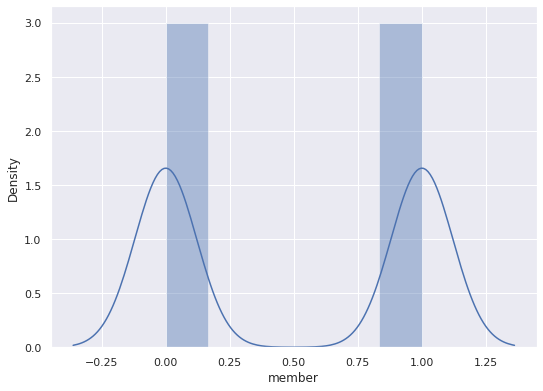

In [196]:
# histogram of PMemb in the training data
sns.distplot(training_set['member'])
plt.show()

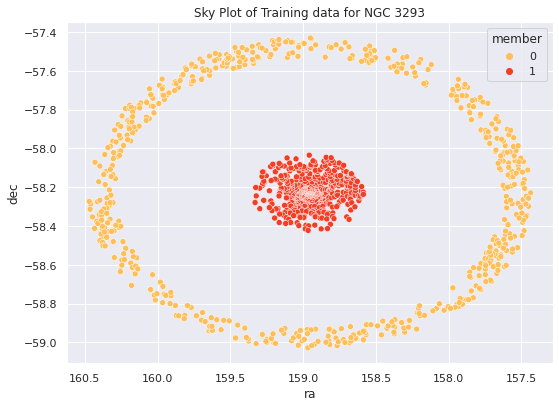

In [197]:
sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', hue = 'member', data = training_data)
skyplot.invert_xaxis()
plt.title('Sky Plot of Training data for NGC 3293')
plt.show()

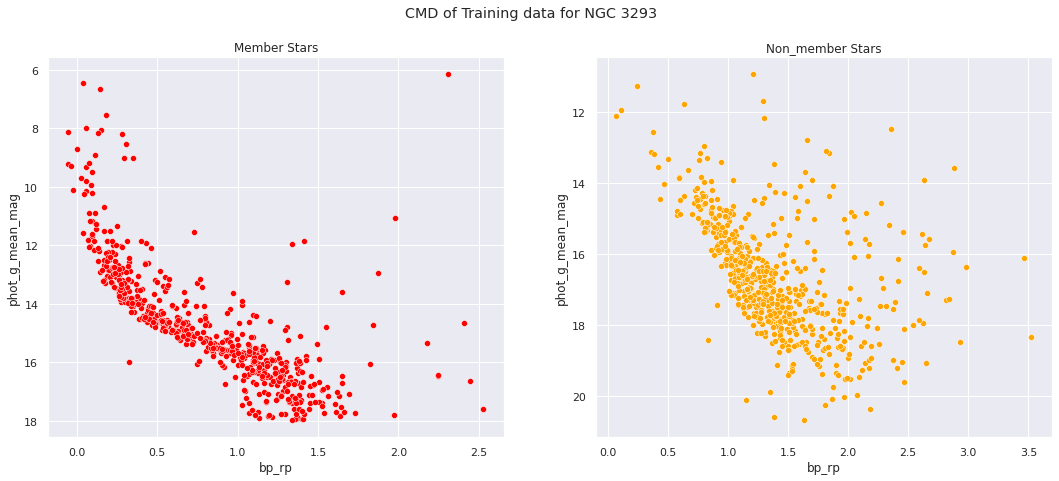

In [198]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)
#cmd = sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', hue = 'PMemb', data = training_data)
#cmd.invert_yaxis()
#plt.title('')
#plt.show()

# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('CMD of Training data for NGC 3293 ')

sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()


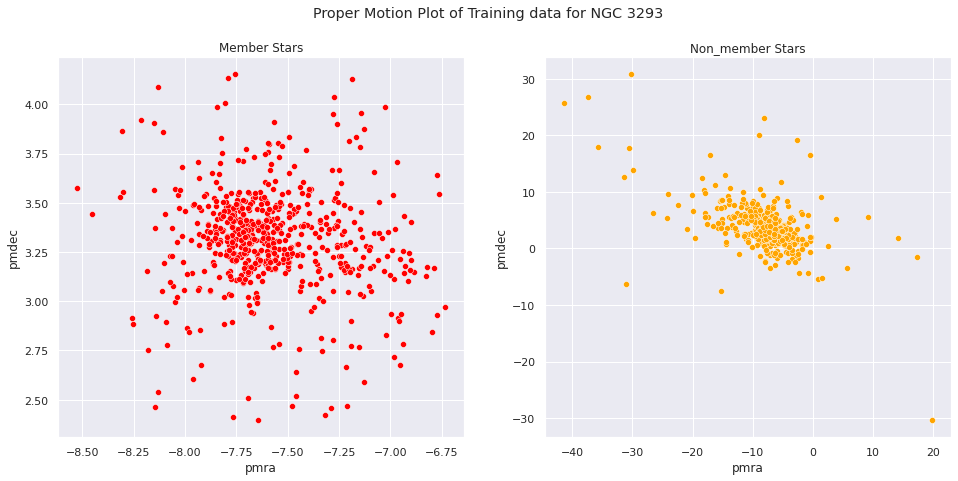

In [199]:
# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Proper Motion Plot of Training data for NGC 3293 ')

sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
#plt.show()
sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


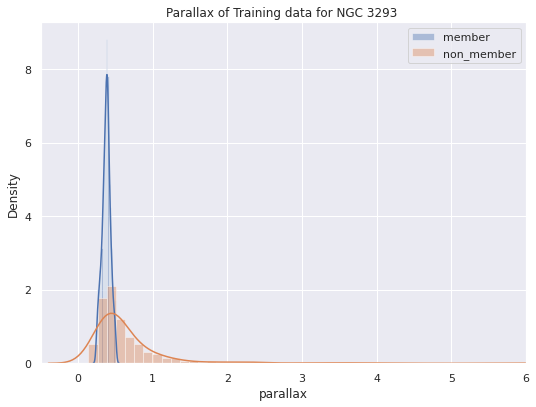

In [200]:
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.xlim(-0.5,6)
plt.title('Parallax of Training data for NGC 3293 ')
plt.legend()
plt.show()

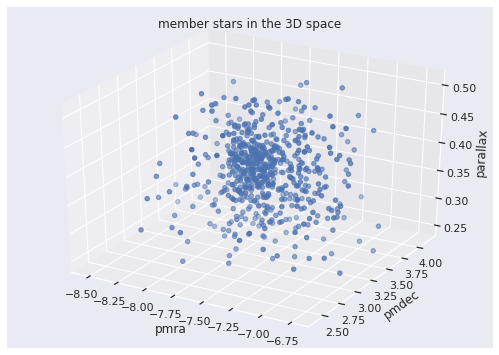

In [201]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


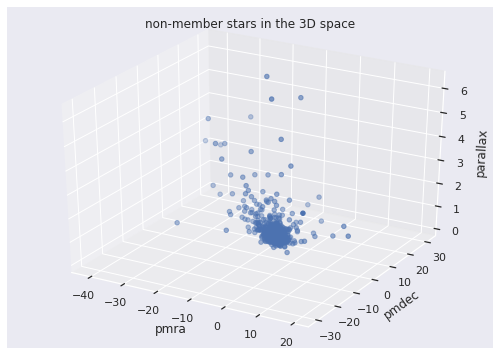

In [202]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


#### Check Feature Importance using Random Forest

In [203]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [204]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

pmra        0.390789
pmdec       0.320321
parallax    0.288890
dtype: float64

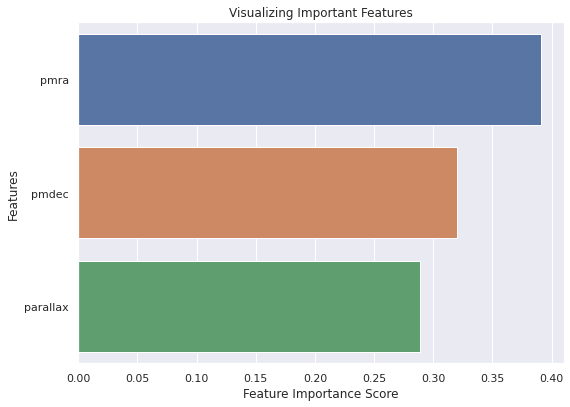

In [205]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Selection and Accuracy Estimate using Test Data

In [206]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report

In [207]:
from sklearn.model_selection import train_test_split
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                                targets, 
                                                                                test_size = 0.3, 
                                                                                random_state=258)

In [208]:
def evaluate_model(model):
    test_predict = model.predict(test_features)
    train_predict = model.predict(train_features)

    print('Model Accuracy:')
    print("Precision on training data: %.3f" % precision_score(train_targets, train_predict))
    print("Precision on testing data: %.3f" % precision_score(test_targets, test_predict))
    print('Accuracy on test data: %.3f' % accuracy_score(test_targets, test_predict))


    sns.heatmap(confusion_matrix(test_targets, test_predict), cmap= 'Greens', annot = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report: \n", classification_report(test_targets, test_predict))

#### Random Forest

In [209]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
ccp_alpha = [2**i for i in range(-10,0)]+[0]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

random_grid

{'bootstrap': [True, False],
 'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5,
  0],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [210]:
rfc = RandomForestClassifier(random_state = 42,
                                    oob_score = True)

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [211]:
rfc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [212]:
rfc_random.best_params_


{'bootstrap': True,
 'ccp_alpha': 0,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.926
Accuracy on test data: 0.951


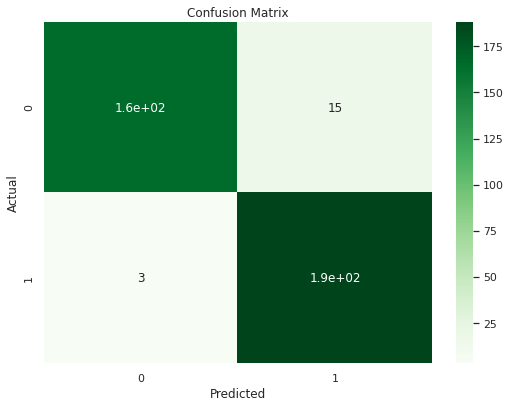

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       180
           1       0.93      0.98      0.95       191

    accuracy                           0.95       371
   macro avg       0.95      0.95      0.95       371
weighted avg       0.95      0.95      0.95       371



In [213]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)
base_model.fit(train_features, train_targets)

evaluate_model(base_model)


Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.926
Accuracy on test data: 0.951


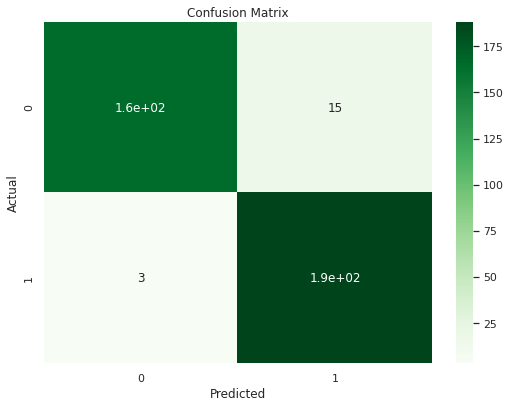

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       180
           1       0.93      0.98      0.95       191

    accuracy                           0.95       371
   macro avg       0.95      0.95      0.95       371
weighted avg       0.95      0.95      0.95       371



In [214]:
best_random = rfc_random.best_estimator_
best_random.fit(train_features, train_targets)

evaluate_model(best_random)


### Prediction for the new stars

In [215]:
# descriptive stats
all_stars_filtered.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_3293_center
count,5.728200e+04,5.728200e+04,5.728200e+04,57282.0,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.000000,57282.0,57282.000000,57278.000000,57278.000000,57282.000000,57282.000000,57282.000000,...,5.600300e+04,5.600300e+04,56003.000000,56003.000000,56002.000000,57282.000000,56002.000000,56016.000000,56003.000000,1216.000000,1216.000000,57282.000000,1216.000000,1216.000000,1216.000000,57282.000000,57282.000000,57282.000000,57282.000000,31559.000000,31559.000000,31559.000000,31559.000000,17476.000000,17476.000000,17476.000000,17476.000000,17476.000000,17476.000000,21240.0,21240.000000,21240.000000,21240.000000,21240.000000,21240.000000,21240.000000,57282.000000,57282.000000,57282.000000,57282.000000
mean,1.635721e+18,5.347289e+18,8.468812e+08,2015.5,158.887514,0.093048,-58.219631,0.088687,0.726621,0.109537,10.907881,-7.687668,0.188147,3.357867,0.176376,-0.038951,-0.239238,-0.221204,0.158521,0.196923,0.214868,-0.040537,0.211665,0.035173,0.089850,231.302608,7.738365,230.007367,1.295241,2.276016,413.838409,0.227101,6.357167,31.0,18.100187,1.497219,0.023958,0.039337,26.457840,15.848696,...,4.239559e+04,1.450693e+02,279.742401,15.786247,1.440258,0.068835,1.337589,0.499863,0.837606,9.291392,2.604573,0.119776,5214.227051,3.382812,-0.082854,285.817989,0.061060,198.471371,-58.801838,100124.091353,5186.741699,4969.877930,5490.913574,0.854514,0.627859,1.115018,0.424561,0.310353,0.555943,200111.0,2.624630,2.353820,2.838082,19.724827,16.246401,23.203205,0.528844,83.179413,41.932517,0.528829
std,0.000000e+00,1.887764e+16,4.877696e+08,0.0,0.766941,0.111000,0.388817,0.105280,0.727687,0.128701,13.822344,5.876498,0.230301,4.248990,0.215638,0.125391,0.110777,0.138900,0.113032,0.111977,0.123015,0.163833,0.110845,0.108207,0.148629,23.945245,40.574500,23.961138,1.812557,9.743853,3961.988281,0.582977,96.854204,0.0,52.833256,0.105811,0.027616,0.062690,2.711576,1.223477,...,2.360100e+06,7.948633e+03,306.641418,1.558982,0.350345,0.309856,0.471890,0.310770,0.295542,26.345393,3.380305,0.892790,667.867310,0.521592,0.342427,0.395168,0.397624,0.753426,0.402388,480.595979,964.229370,936.811523,1002.773010,0.671613,0.643691,0.715477,0.337198,0.320729,0.361912,0.0,6.745950,6.076413,7.306827,591.758972,476.132080,708.101318,0.189469,91.584389,52.768417,0.189490
min,1.635721e+18,5.254570e+18,1.522900e+04,2015.5,157.435614,0.012693,-59.029445,0.012876,0.09002

In [216]:
# chosing only GAIA stars close to 0.40 degree radius of the center
all_stars_filtered = all_stars_filtered.dropna(subset = feature_columns)
GAIA_target_stars = all_stars_filtered[all_stars_filtered['dist_3293_center'] <= cantat_radius*2]

In [217]:
# removing the member stars from GAIA data
GAIA_target_stars = pd.concat([GAIA_target_stars, training_data.drop(columns=['PMemb', 'member']), 
                               training_data.drop(columns=['PMemb', 'member'])]).drop_duplicates(keep=False)

In [218]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [219]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [220]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = best_random.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    13127
1     1120
Name: member, dtype: int64

In [221]:
# estimate the membership probability of the stars
GAIA_target_stars['PMemb'] = best_random.predict_proba(new_features)[:,1]
sum(GAIA_target_stars['PMemb'] >= 0.5)

1125

In [222]:
potentialMember = GAIA_target_stars[GAIA_target_stars['member'] == 1]
len(potentialMember)

1120

In [223]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_3293_center,member,PMemb
count,1.120000e+03,1.120000e+03,1.120000e+03,1120.0,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.0,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,...,1114.000000,1114.000000,1114.000000,1120.000000,1114.000000,1114.000000,1114.000000,14.000000,14.000000,1120.000000,14.000000,14.000000,14.0,1120.000000,1120.000000,1120.000000,1120.000000,848.000000,848.000000,848.000000,848.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,472.0,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.0,1120.000000
mean,1.635721e+18,5.351231e+18,8.335878e+08,2015.5,158.840879,0.049124,-58.224546,0.047840,0.367117,0.057998,8.302939,-7.403754,0.097672,3.299862,0.093194,-0.035402,-0.233932,-0.222219,0.189102,0.219490,0.249988,-0.077616,0.216212,0.063194,0.091939,233.529464,13.324107,232.266071,1.263393,1.109662,263.898010,0.063287,0.974121,31.0,27.540312,1.538677,0.012534,0.041468,26.673214,15.929464,...,348.775513,15.136236,1.338690,0.055357,1.175656,0.461262,0.714394,11.090173,1.667645,0.062500,4928.571289,3.357143,0.0,285.798243,0.045956,198.442958,-58.823343,100149.669811,5470.289062,5207.596680,5802.927246,1.176216,0.894300,1.476626,0.584501,0.442280,0.735810,200111.0,3.591057,3.217281,3.894536,52.977016,45.475384,60.478672,0.296835,100.242081,46.537876,0.296844,1.0,0.817271
std,0.000000e+00,3.431674e+14,4.890565e+08,0.0,0.410948,0.026401,0.210055,0.025476,0.075673,0.031014,4.820221,0.411987,0.052734,0.389667,0.049533,0.133297,0.106564,0.161812,0.101847,0.116675,0.113178,0.177167,0.091879,0.096407,0.136330,20.222688,52.678238,20.270880,1.854709,4.160980,138.747070,0.123712,3.809638,0.0,62.951500,0.096811,0.006906,0.061643,2.292779,1.054980,...,302.841187,1.490785,0.148932,0.243903,0.491183,0.271282,0.256536,14.805199,2.018653,0.596104,432.218903,0.633324,0.0,0.211970,0.214527,0.405178,0.216672,524.881672,1273.534180,1213.503906,1314.567139,0.657299,0.669303,0.654916,0.330666,0.332742,0.333535,0.0,5.775493,5.297784,6.061995,678.147949,593.103271,763.215393,0.079979,52.619438,24.932832,0.079970,0.0,0.151118
min,1.635721e+18,5.350662e+18,3.483190e+05,2015.5,158.189691,0.014418,-58.628597,0.014595,0.135661,0.017599,3.002131,-8.610634,0.029306,2.401060,0.027629,-0.853866,-0.736077,-0.643190,-0.263703,-0.212499,-0.242035,-0.649466,-0.348651,-0.268684,-0.560040,90.000000,0.00000

In [224]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3293_center,member
count,6.170000e+02,6.170000e+02,6.170000e+02,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,606.000000,606.000000,606.000000,617.000000,606.000000,606.000000,606.000000,4.000000,4.000000,617.000000,4.000000,4.000000,4.0,617.000000,617.000000,617.000000,617.000000,542.000000,542.000000,542.000000,542.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,289.0,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.0
mean,1.635721e+18,5.351256e+18,8.363382e+08,2015.5,158.941904,0.041943,-58.223179,0.040669,0.377758,0.048224,9.646549,-7.585979,0.081004,3.312147,0.078552,-0.034065,-0.277253,-0.289735,0.269403,0.176014,0.343567,-0.078138,0.187742,0.107994,0.056990,202.012966,30.241491,200.594814,1.418152,1.933214,253.842484,0.045447,0.890093,31.0,57.463230,1.612082,0.009867,-0.019965,23.179903,14.363047,...,415.899536,14.194469,1.287667,0.126418,0.800674,0.281763,0.518911,-4.272901,1.939050,0.047002,5125.000000,3.750000,0.0,285.843385,0.074071,198.511906,-58.784460,100244.710332,6671.687500,6329.378418,7030.716309,0.887406,0.594932,1.159183,0.445821,0.296745,0.580796,200111.0,4.597406,4.195796,5.021256,204.749573,168.066162,241.432739,0.088519,116.088744,52.011062,0.623826,0.088529,1.0
std,0.000000e+00,3.282539e+14,4.900179e+08,0.0,0.143802,0.022872,0.071464,0.021987,0.055162,0.025881,4.179525,0.297270,0.043753,0.258574,0.041686,0.130535,0.128759,0.134003,0.110426,0.135790,0.107464,0.168650,0.121315,0.124428,0.137145,29.852339,69.235916,29.937237,2.198035,4.982976,161.599686,0.100777,3.780193,0.0,91.347198,0.104319,0.005260,0.067146,3.384224,1.805780,...,295.304871,1.807223,0.122409,0.369581,0.480531,0.217601,0.284884,16.832975,2.896037,0.634041,478.713562,0.866025,0.0,0.077342,0.069729,0.147941,0.070473,654.799456,1716.841797,1620.376953,1746.008789,0.403292,0.382866,0.449504,0.203589,0.190589,0.229465,0.0,32.267616,30.286135,35.228199,3162.824707,2605.815430,3719.859619,0.055579,47.873137,21.882236,0.332883,0.055593,0.0
min,1.635721e+18,5.350689e+18,4.845840e+05,2015.5,158.586102,0.016119,-58.422563,0.014866,0.249344,0.017534,3.011133,-8.527944,0.030638,2.396999,0.029315,-0.656215,-0.756654,-0.869462,-0.153854,-0.480639,-0.222594,-0.718883,-0.488736,-0.576839,-0.569122,61.000000,0.000000,61.000000,0.000000,-5.831085,35.025322,0.000000,

#### Visualization

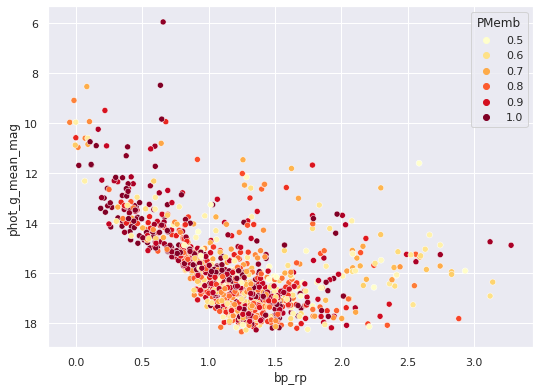

In [225]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'bp_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
cmd.invert_yaxis()

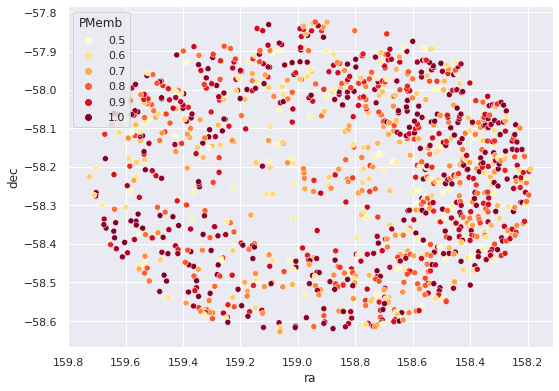

In [226]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
skyplot.invert_xaxis()

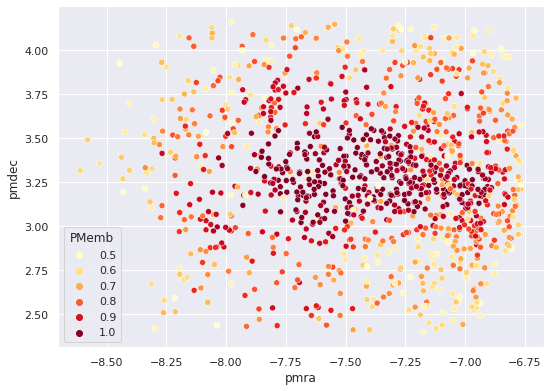

In [227]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )


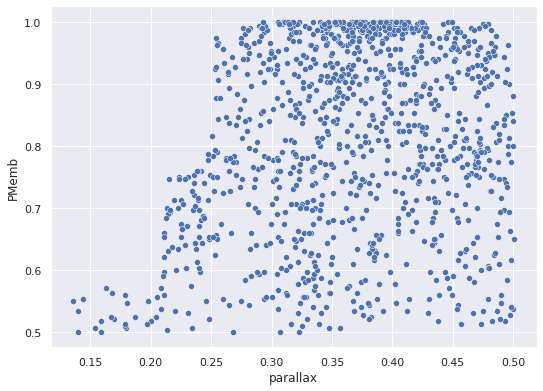

In [228]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )

In [229]:
# saving the files as csv
# all_stars.to_csv('gaia_3293_membership_prob.csv')

potentialMember.to_csv('NGC_3293_membership_prob.csv')


### Comparing the old and new predicted members

In [230]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])


In [231]:
concatenated.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_3293_center,member,PMemb
count,1.737000e+03,1.737000e+03,1.737000e+03,1737.0,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.0,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,...,1720.000000,1720.000000,1720.000000,1737.000000,1720.000000,1720.000000,1720.000000,18.000000,18.000000,1737.000000,18.000000,18.000000,18.0,1737.000000,1737.000000,1737.000000,1737.000000,1390.000000,1390.000000,1390.000000,1390.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,761.0,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.0,1737.000000
mean,1.635721e+18,5.351240e+18,8.345648e+08,2015.5,158.876764,0.046573,-58.224060,0.045292,0.370897,0.054526,8.780197,-7.468483,0.091752,3.304226,0.087993,-0.034927,-0.249320,-0.246202,0.217626,0.204047,0.283228,-0.077802,0.206099,0.079108,0.079525,222.334485,19.333333,221.016120,1.318365,1.402196,260.326141,0.056950,0.944273,31.0,38.169254,1.564751,0.011587,0.019646,25.432355,15.373057,...,372.424927,14.804420,1.320715,0.080599,1.043541,0.398019,0.645520,7.676157,1.727957,0.056995,4972.222168,3.444444,0.0,285.814278,0.055943,198.467449,-58.809531,100186.728777,5938.747070,5645.011230,6281.676270,1.055191,0.768850,1.343603,0.526387,0.381294,0.670852,200111.0,3.973231,3.588884,4.322425,110.614662,92.030983,129.198410,0.222839,105.870977,48.482007,0.222848,1.0,0.748557
std,0.000000e+00,3.380636e+14,4.892588e+08,0.0,0.344286,0.025431,0.173936,0.024529,0.069260,0.029658,4.646379,0.385193,0.050353,0.348760,0.047405,0.132286,0.116759,0.155864,0.111762,0.125502,0.119839,0.174141,0.104160,0.109292,0.137601,28.415781,59.626072,28.508887,1.984233,4.486233,147.303543,0.116370,3.798328,0.0,75.633904,0.105535,0.006495,0.070100,3.201409,1.561021,...,301.830444,1.670614,0.142230,0.296598,0.519213,0.267715,0.282665,16.149786,2.147019,0.609713,436.302032,0.683608,0.0,0.177628,0.177684,0.338639,0.179917,580.643070,1575.007690,1490.030396,1612.452759,0.582212,0.585673,0.598215,0.292314,0.290827,0.303984,0.0,20.383102,19.110445,22.211645,2020.203369,1671.737305,2369.039795,0.123142,51.531655,24.030752,0.123141,0.0,0.250232
min,1.635721e+18,5.350662e+18,3.483190e+05,2015.5,158.189691,0.014418,-58.628597,0.014595,0.135661,0.017534,3.002131,-8.610634,0.029306,2.396999,0.027629,-0.853866,-0.756654,-0.869462,-0.263703,-0.480639,-0.242035,-0.718883,-0.488736,-0.576839,-0.569122,61.000

In [232]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_3293_center,member
count,6.170000e+02,6.170000e+02,6.170000e+02,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,606.000000,606.000000,606.000000,617.000000,606.000000,606.000000,606.000000,4.000000,4.000000,617.000000,4.000000,4.000000,4.0,617.000000,617.000000,617.000000,617.000000,542.000000,542.000000,542.000000,542.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,289.0,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.0
mean,1.635721e+18,5.351256e+18,8.363382e+08,2015.5,158.941904,0.041943,-58.223179,0.040669,0.377758,0.048224,9.646549,-7.585979,0.081004,3.312147,0.078552,-0.034065,-0.277253,-0.289735,0.269403,0.176014,0.343567,-0.078138,0.187742,0.107994,0.056990,202.012966,30.241491,200.594814,1.418152,1.933214,253.842484,0.045447,0.890093,31.0,57.463230,1.612082,0.009867,-0.019965,23.179903,14.363047,...,415.899536,14.194469,1.287667,0.126418,0.800674,0.281763,0.518911,-4.272901,1.939050,0.047002,5125.000000,3.750000,0.0,285.843385,0.074071,198.511906,-58.784460,100244.710332,6671.687500,6329.378418,7030.716309,0.887406,0.594932,1.159183,0.445821,0.296745,0.580796,200111.0,4.597406,4.195796,5.021256,204.749573,168.066162,241.432739,0.088519,116.088744,52.011062,0.623826,0.088529,1.0
std,0.000000e+00,3.282539e+14,4.900179e+08,0.0,0.143802,0.022872,0.071464,0.021987,0.055162,0.025881,4.179525,0.297270,0.043753,0.258574,0.041686,0.130535,0.128759,0.134003,0.110426,0.135790,0.107464,0.168650,0.121315,0.124428,0.137145,29.852339,69.235916,29.937237,2.198035,4.982976,161.599686,0.100777,3.780193,0.0,91.347198,0.104319,0.005260,0.067146,3.384224,1.805780,...,295.304871,1.807223,0.122409,0.369581,0.480531,0.217601,0.284884,16.832975,2.896037,0.634041,478.713562,0.866025,0.0,0.077342,0.069729,0.147941,0.070473,654.799456,1716.841797,1620.376953,1746.008789,0.403292,0.382866,0.449504,0.203589,0.190589,0.229465,0.0,32.267616,30.286135,35.228199,3162.824707,2605.815430,3719.859619,0.055579,47.873137,21.882236,0.332883,0.055593,0.0
min,1.635721e+18,5.350689e+18,4.845840e+05,2015.5,158.586102,0.016119,-58.422563,0.014866,0.249344,0.017534,3.011133,-8.527944,0.030638,2.396999,0.029315,-0.656215,-0.756654,-0.869462,-0.153854,-0.480639,-0.222594,-0.718883,-0.488736,-0.576839,-0.569122,61.000000,0.000000,61.000000,0.000000,-5.831085,35.025322,0.000000,

In [233]:
concatenated.dataset.value_counts()

New_member    1120
Old_member     617
Name: dataset, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

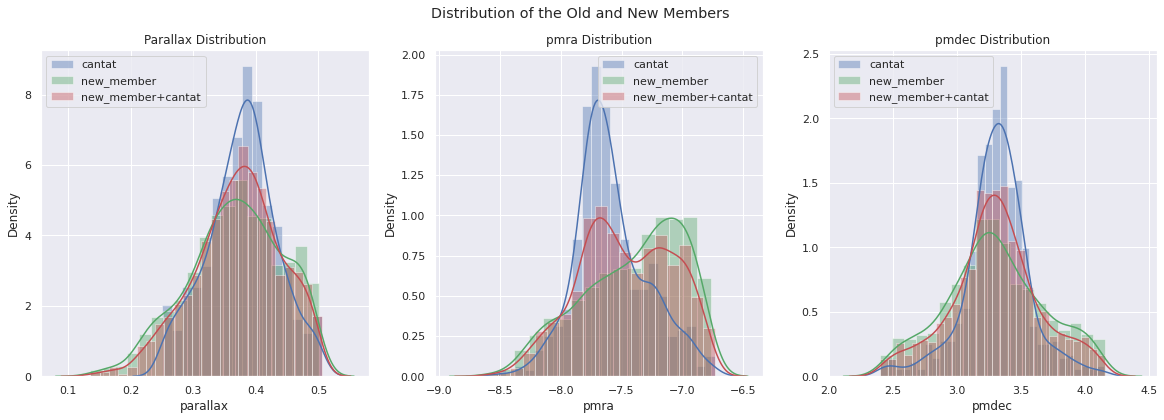

In [234]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


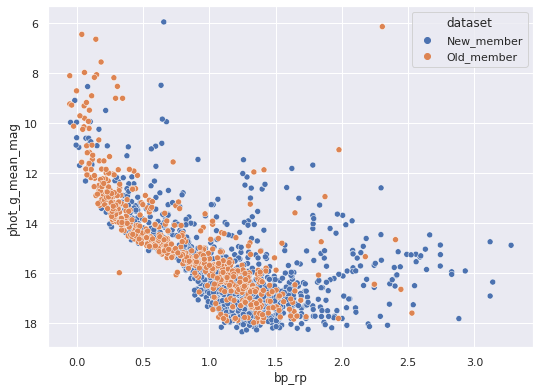

In [235]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset')
cmd.invert_yaxis()

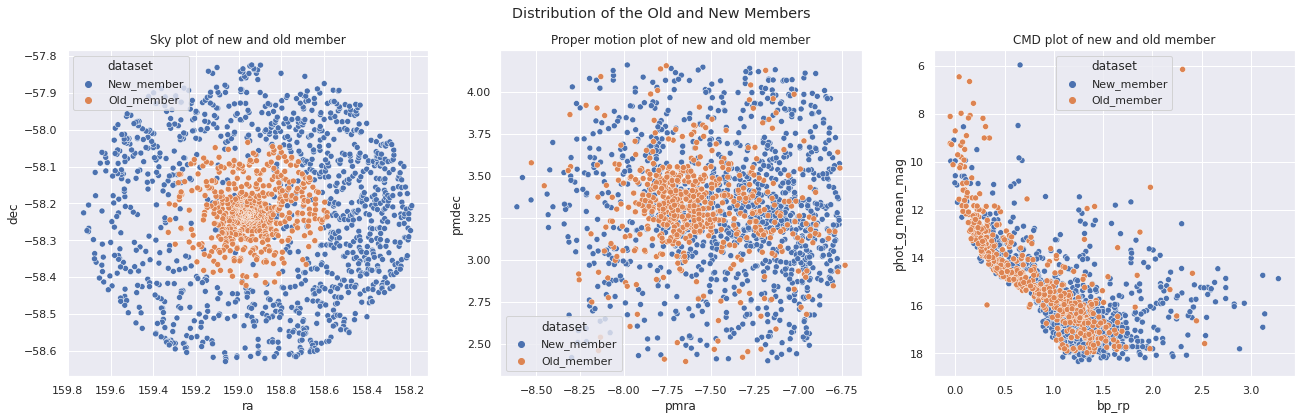

In [236]:
fig, axes = plt.subplots(1, 3, figsize=(22,6))
fig.suptitle('Distribution of the Old and New Members')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset', ax=axes[0])
skyplot.invert_xaxis()
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1])
axes[1].set_title('Proper motion plot of new and old member')

cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset', ax = axes[2])
cmd.invert_yaxis()
axes[2].set_title('CMD plot of new and old member')

plt.show()

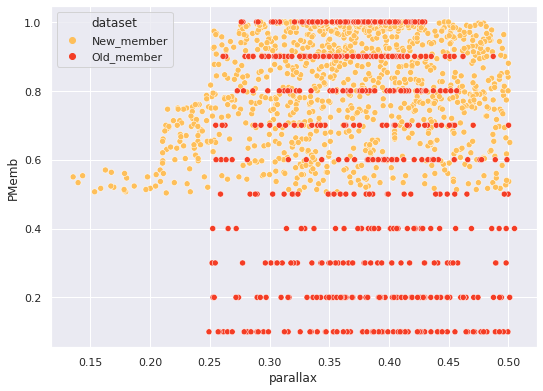

In [237]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [238]:
# pd_prof.ProfileReport(potentialMember)

In [239]:
#files.download('NGC_3293_cantat.csv')

#files.download('NGC_3293_membership_prob.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


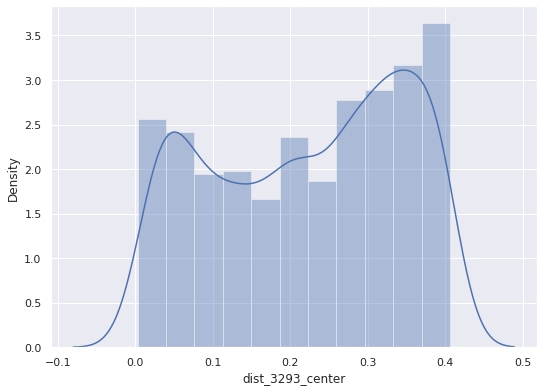

In [240]:
sns.distplot(concatenated['dist_3293_center'])

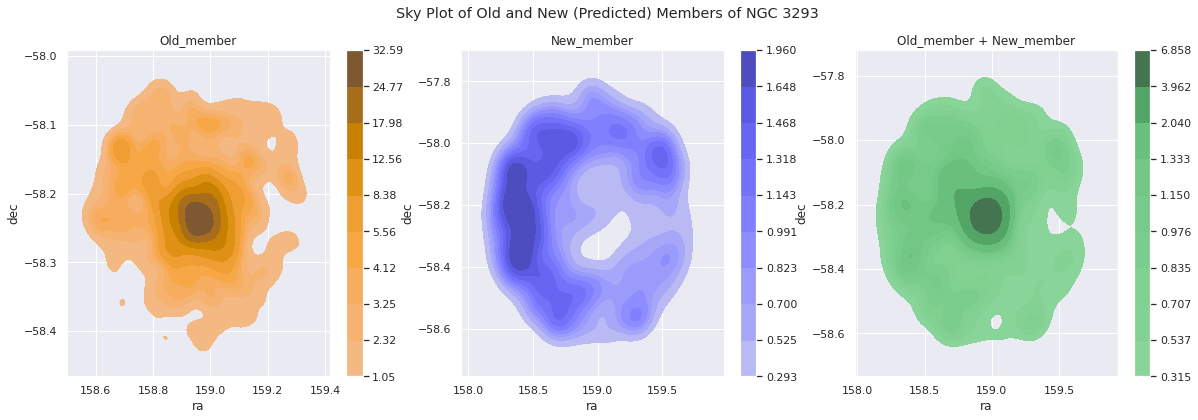

In [241]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of NGC 3293')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

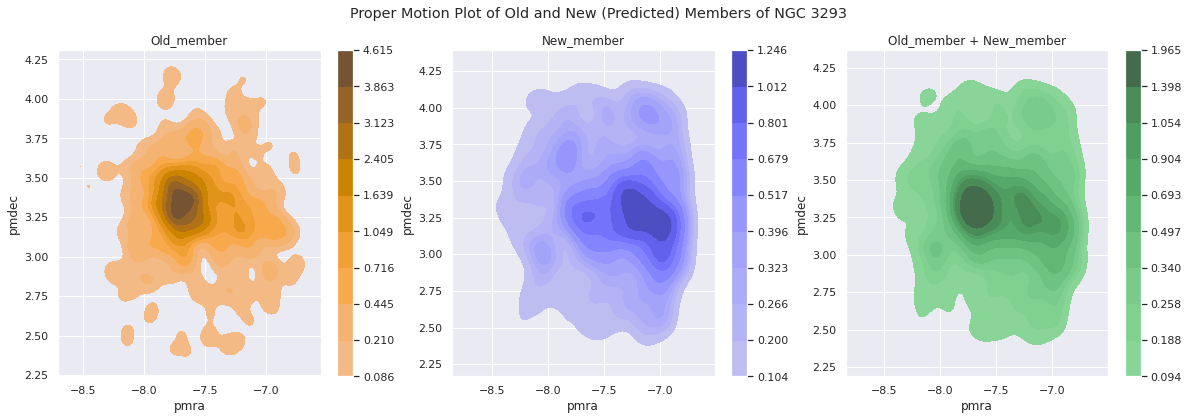

In [242]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of NGC 3293')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

In [243]:
#files.download('NGC_3293_cantat.csv')

potentialMember.to_csv('NGC_3293_additional_member_prob.csv')
concatenated.to_csv('NGC_3293_all_member_prob.csv')

files.download('NGC_3293_all_member_prob.csv')
# column 'dataset': Old_member, New_member
# column 'member': 0 and 1
# column 'PMemb': decimal values between 0 to 1

files.download('NGC_3293_additional_member_prob.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>